### Summary

&emsp; 

&emsp; The folder containing this notebook is expected to contain a utils.py script (containing custom functions for data wrangling and analysis) and the EMG_data folder (downloaded from: http://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures#)

In [76]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#load custon functions
from utils import *

### Signal Features

&emsp; Extracting features from the input signal is a crucial step in any classification problem. Two different types of features can be computed for time-series data: 1) time-domain (TD) features and 2) frequency-domain (FD) features. Spiewak et al., (2018) summarize vaious features that can be used to characterize EMG signals. Any of these, in isolation or combination, could be helpful for the problem of gesutre classification at hand. 
Thankfully, Osokei & Hu (2008) conducted a systematic study of various TD and FD features for the purpose of decoding upper limb positions from EMG data. The authors find two TD features that are most informative about upper limb movements: Mean Absolute Value (MAV) and Wavelength (WL). Moreover, the authors find that performance of an SVM classifier is optimized when these features are computed over non-overlapping segments of the data 200 ms in length. 


&emsp; I leveraged the results as a starting off point for the task of classifying limb position from the EMG data in this data set. It's possible that these features are deficient in some way (e.g., not robust to different subjects or limited in the types of movements that can be decoded from them). Therefore, an obvious extension of the work presented here would be to see if features other than the ones used here provide more robust clasification model. 

&emsp; The code block below loads, preprocesses, and computes the features over all collected data for a given subject. 

In [7]:
# Process data and get features 

#define where the data file are located
data_folder = './EMG_data/01'

# Processing pipeline
# 1) Re-sample timeseries to steady sampling rate
# 2) Bandpass filter
# 3) Segment data into 200 ms segments (exclude segments with more than 1 label)
# 4) Compute features in each segment

# User-defined parameters

lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 200 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

feature_matrix, target_labels, window_tstamps, \
block_labels, series_labels = get_subject_data_for_classification(data_folder, lo_freq, hi_freq, \
                                                                  win_size, step)

# resulting feature_matrix has dimension [nsamples, nfeatures]

nsamples, nfeat = feature_matrix.shape
print(feature_matrix.shape)

(604, 16)


&emsp; Before feeding the data into a classifier function, it's useful to know the distribution of sample counts for each class. Having a heavily over-represented class can lead to a biased estimate of model performance since the cost function can be minimized by always classifying as the majority class. 

&emsp; The table and plot plot below shows the sample count for each class

   Target Labels  Value Count
0              1           36
1              2           33
2              3           36
3              4           33
4              5           35
5              6           36


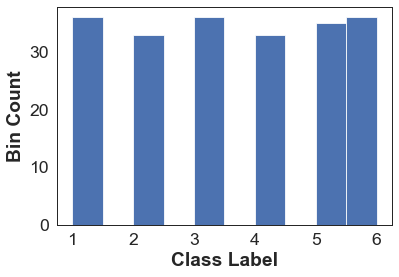

In [8]:
#exclude unlabeled data
in_samples = np.where(target_labels != 0)[0]
feature_matrix_in = feature_matrix[in_samples,:]
target_labels_in = target_labels[in_samples]

#show histogram for target labels
plt.hist(target_labels_in.astype('int'))
plt.xlabel('Class Label');
plt.ylabel('Bin Count');

#Display bin count values as well
y = np.bincount(target_labels_in.astype('int'))
ii = np.nonzero(y)[0]
print(pd.DataFrame(np.vstack((ii,y[ii])).T,columns = ['Target Labels','Value Count']))

**Observations:** As can be seen, the samples are roughly balanced. The mismatch in samples is not great enough to be an issue. However, in this context an F1 measure will be superior to accuracy in assesing classifier performance. 

&emsp; Before going on to build the classification model, it's also useful to examine the similarity of samples from different classes. This can give an idea of whether there's actually some structure in the data the classifier has a chance of finding. Below I perform a dimensionality reduction and visualize the results. tSNE was best at revealing the structure of the data. 

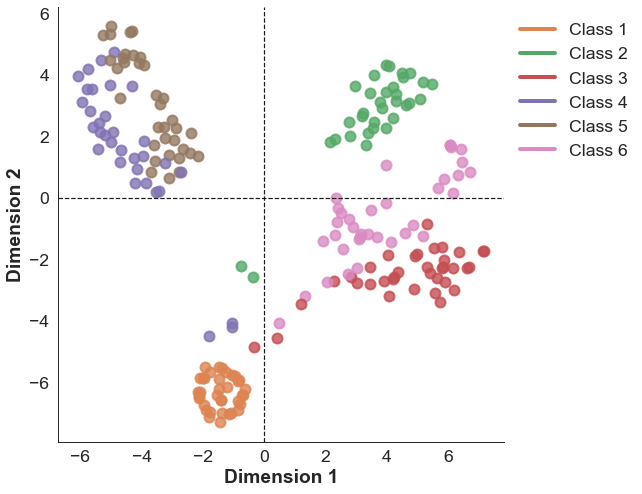

In [9]:
#tsne
np.random.seed(42)#to replicate stochastic aspect of dimensionality recution
fig = dim_reduction_visualization(feature_matrix_in, target_labels_in)

**Observations:** The scatter plots above show the low-dimensionality embedding for each of the labeled segments in the data ussed to train and evaluate the classifier. Dot color depicts the class of the sample. As can be seen, the samples mostly cluster according to the class to which they belong to, which means there's some meaningul structure in the data that the classifier can find. Some degree of overlap may be due to the difficulty in embedding the high-dimensional feature space into just two dimensions.


&emsp; The code blocks below train and evaluates a model based on simple logistic regression to classify limb position from the pattern of signals across electrodes. In order to put the performance in context, it's useful to also measure classifier performance after randomly shuffling the class labels (i.e., erasing the relationship between signal and class).

Some details on data preparation and the model
+ Values are standardized across samples within each feature dimension
+ Logistic regression is trained without regularization (simple model is good enough).
+ Using cross-entropy for loss function
+ Model performance is assesed on the held-out set with stratified k-fold cross-validation which keeps the class balance across train/test splits.

In [78]:
# Train and evaluate logistic regression classifier 

# Initialize empty lists
results_df = []
prob_class = np.empty((0,0,0))

# Set seed for replicability
np.random.seed(1)

# Repeat analysis over multiple repetitions to take into account stochasticity of experiment
nreps = 10
for rep in range(nreps):
    
    # Feed data into function for training and evaluation
    train_f1, test_f1, prob_class_rep = log_reg_on_labeled_data(feature_matrix, target_labels,window_tstamps,\
                                                                          series_labels, nsplits = 3, \
                                                                      penalty = 'none', \
                                                                      multiclass = 'multinomial')
    
    # Put results in dataframe
    results_df.append(pd.DataFrame({'F1_score':train_f1,\
                                    'Rep':[rep+1 for x in range(train_f1.size)],\
                                    'Fold': np.arange(train_f1.size)+1,\
                               'Shuffled':[False for x in range(train_f1.size)],\
                               'Type':['Train' for x in range(train_f1.size)]}))
    
    results_df.append(pd.DataFrame({'F1_score':test_f1,\
                                    'Rep':[rep+1 for x in range(test_f1.size)],\
                                    'Fold': np.arange(test_f1.size)+1,\
                               'Shuffled':[False for x in range(test_f1.size)],\
                               'Type':['Test' for x in range(test_f1.size)]}))
    
    #concatenate class probabilities
    prob_class = np.dstack((prob_class, prob_class_rep)) if prob_class.size else prob_class_rep



# Run classifier with shuffled data (null hypothesis)
for rep in range(nreps):
    #train and evaluate a classifer shuffling the class labels
    train_f1, test_f1, dummy = log_reg_on_labeled_data(feature_matrix, target_labels, window_tstamps,\
                                                                            series_labels,  nsplits = 3, \
                                                                      penalty = 'none', \
                                                                      multiclass = 'multinomial', permute = True)
    # Put results in dataframe
    results_df.append(pd.DataFrame({'F1_score':train_f1,\
                                    'Rep':[rep+1 for x in range(train_f1.size)],\
                                    'Fold': np.arange(train_f1.size)+1,\
                               'Shuffled':[True for x in range(train_f1.size)],\
                               'Type':['Train' for x in range(train_f1.size)]}))
    
    results_df.append(pd.DataFrame({'F1_score':test_f1,\
                                    'Rep':[rep+1 for x in range(test_f1.size)],\
                                    'Fold': np.arange(test_f1.size)+1,\
                               'Shuffled':[True for x in range(test_f1.size)],\
                               'Type':['Test' for x in range(test_f1.size)]}))
    
#concatenate all dataframes
results_df = pd.concat(results_df, axis =0)
#average over folds
results_df = results_df.groupby(['Shuffled','Type','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold'])

# Output summary
display(HTML(results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Rep']).to_html()))

#Compare real and null distributions. Output p-value

tstat, pval_test = scipy.stats.ttest_ind(results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == False)]['F1_score'].values,\
                                         results_df.loc[(results_df.Type == 'Test')&(results_df.Shuffled == True)]['F1_score'].values)
print('Test performance pval: %E' %(pval_test))


Test performance pval: 2.928260E-23


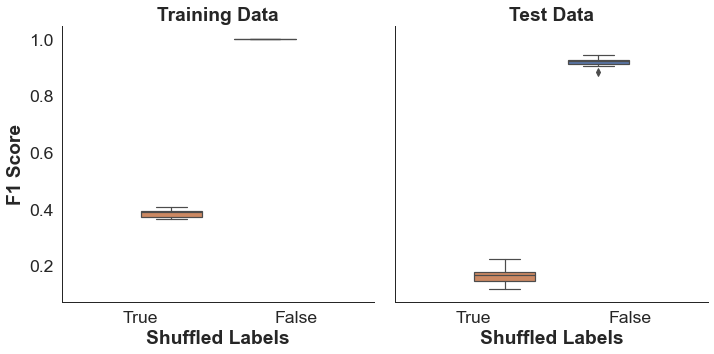

In [54]:

#Visualize results
g = sns.catplot(data = results_df, x= 'Shuffled', y = 'F1_score', hue = 'Shuffled',\
            col = 'Type',kind = 'box', order = [True,False], col_order = ['Train','Test'])
#Label axes and subpots
for ax in g.axes[0]:
    ax.set_xlabel('Shuffled Labels')
g.axes[0][0].set_ylabel('F1 Score')
g.axes[0][0].set_title('Training Data',fontweight = 'bold');
g.axes[0][1].set_title('Test Data',fontweight = 'bold');

**Observations:**  The boxplots above show classifier performance for training and testing partitions of the data over multiple repetitions of the train/test splits. Results are shown for the actual data (blue) and shuffled-label data (yellow). I also display the p-value of the 2-sample t-tests comparinf the real and shuffled data distributions for the test performance.

&emsp; As can be seen test performance of the classifier is quite good (.92 F1 score score on average). One limitation of the above approach is that temporal information has been completely discarded because features from each data segment are treated independently. There are two approaches to actually make use of the temporal information in the data:

1) Add a 'majority voting' stage to the current model:  Below, I visualize the probability of each class over the whole acquisition period. The class probability within the labeled periods was inferred using held out data. From this plot we can see that neighboring timepoints tend to be classified to the same class. There are some periods where the classifier alternates between class label predictions. These periods could be 'smoothed out' by adding stage of the model where the final class label for each segment is decided based on the majority class labels for a small number neighboring of timepoints. This is a weak approach to incroporate the tempral stucture of the data into our model. 

2) Use a Recursive Neural Network (RNN) architecture: RNNs can leverage the history of patterns in a sequence to make predictions about future timepoints. RNNs can also be made bidirectional to take into account past and future time points, though this increases the number of parameters in the model. Results from this approach are explored in another notebook.


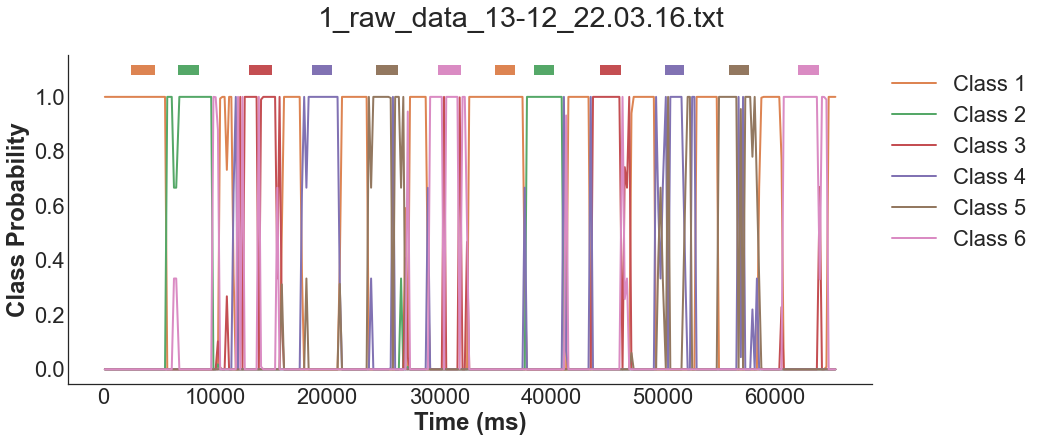

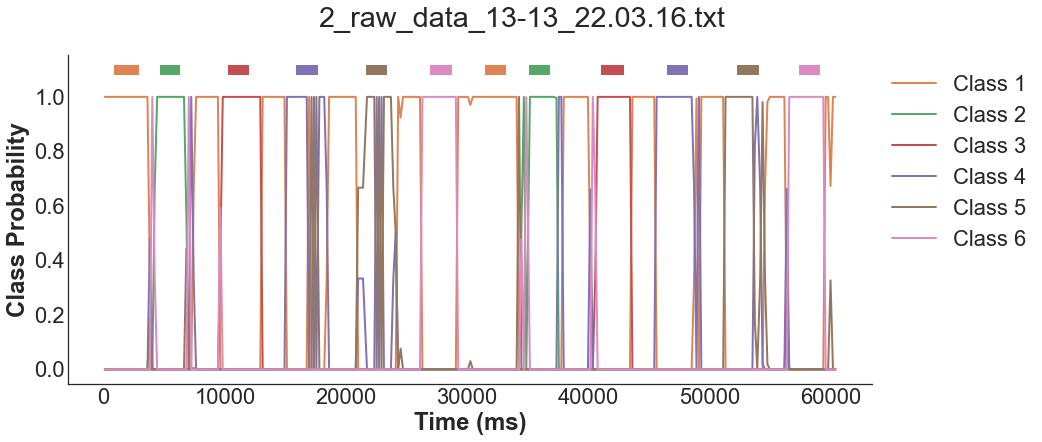

In [80]:
#visualize class probability over time.
fig = visualize_time_series_prob(data_folder, np.squeeze(prob_class[:,:,0]), window_tstamps, series_labels)

**Observations:** The plots above also suggest that the 'unmarked' periods of the data correspond to transsitions between movements because the most probable class labels during these periods correspond to the labels from the adjacent labeled periods.

In [ ]:
np.argmax(prob_class)

In [82]:
np.squeeze(prob_class[:,:,0]

array([[1.00000000e+00, 3.21362608e-25, 3.39454397e-10, 3.77738039e-17,
        1.65350741e-12, 6.14501437e-35],
       [9.99999984e-01, 2.28514486e-28, 1.64210310e-08, 4.91761367e-12,
        5.50556474e-18, 1.14868223e-27],
       [1.00000000e+00, 1.84803248e-26, 1.76949951e-12, 2.21151164e-12,
        5.10912843e-17, 4.30287550e-30],
       ...,
       [6.73295216e-01, 1.23538157e-17, 1.05888989e-17, 2.68896284e-23,
        3.26704784e-01, 6.87889755e-49],
       [9.99999827e-01, 3.66188136e-31, 1.05799944e-12, 1.73082160e-07,
        1.11146064e-23, 2.29574678e-27],
       [9.99999966e-01, 1.06786213e-29, 8.67434200e-11, 3.43416874e-08,
        1.99458573e-21, 9.55543668e-27]])